# 1. Settings

## 1-1. Set Home

In [1]:
import os
HOME=os.getcwd()
print(HOME)

/content


## 1-2. Clone YOLO v5 & Install requirements.txt

In [2]:
%cd {HOME}
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt

import torch
import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-176-g76ea9ed Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.0/78.2 GB disk)


## 1-3. Use custom model - single frame

In [3]:
from typing import Generator

import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline


def generate_frames(video_file: str) -> Generator[np.ndarray, None, None]:
    video = cv2.VideoCapture(video_file)
    while video.isOpened():
        success, frame = video.read()
        if not success:
            break
        yield frame

    video.release()

def plot_image(image: np.ndarray, size: int = 12) -> None:
    %matplotlib inline 
    plt.figure(figsize=(size, size))
    plt.imshow(image[...,::-1])
    plt.show()

### 1-3.a. Test Custom Model

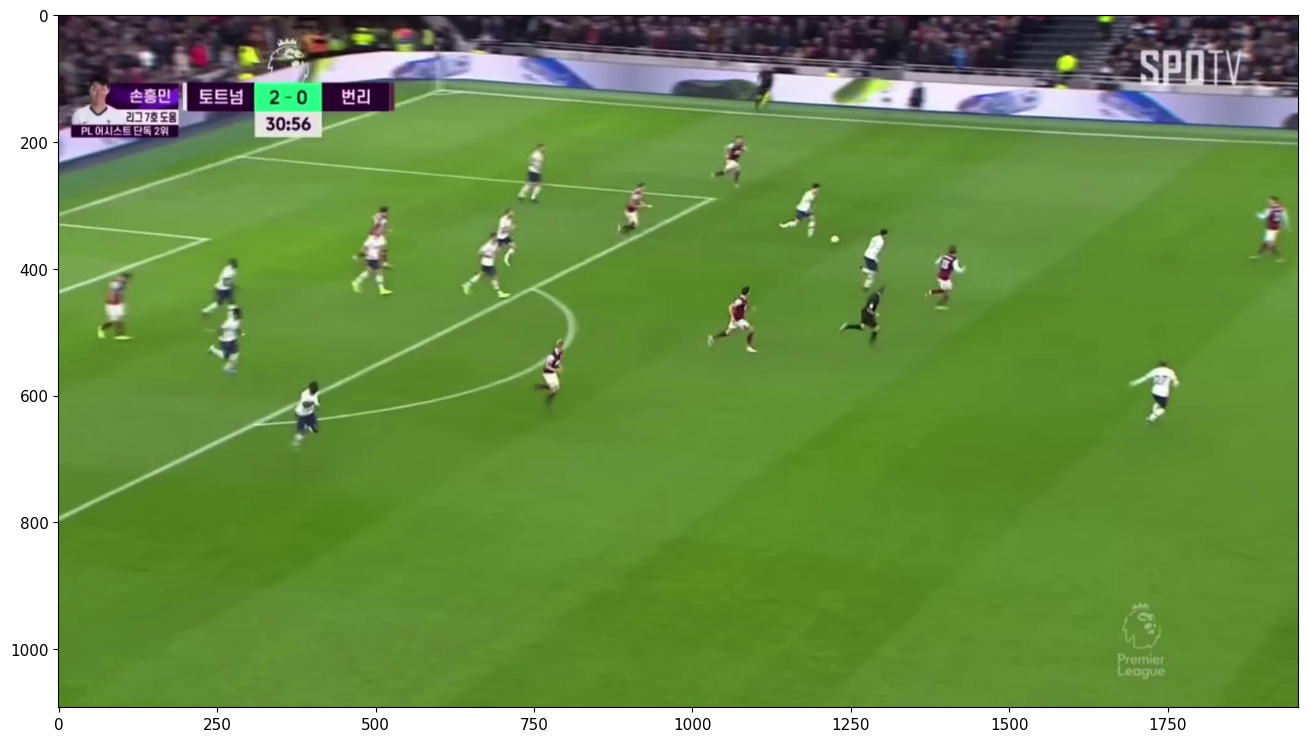

In [82]:
SOURCE_VIDEO_PATH = f"{HOME}/clips/son_football.mp4"
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))
frame = next(frame_iterator)
plot_image(frame, 16)

## 1-4. Use trained `best.pt`

In [6]:
WEIGHTS_PATH = f"{HOME}/best.pt"

## 1-5. Load a Model

In [7]:
WEIGHTS_PATH = f"{HOME}/best.pt"
model = torch.hub.load('ultralytics/yolov5', 'custom', WEIGHTS_PATH)
results = model(frame, size=1280)
results.pandas()
results.pred[0]
model.names

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-176-g76ea9ed Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 416 layers, 139999708 parameters, 0 gradients, 207.9 GFLOPs
Adding AutoShape... 


{0: 'ball', 1: 'goalkeeper', 2: 'player', 3: 'referee'}

## 1-6. Install ByteTrack

In [8]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
!cd ByteTrack && pip3 install -r requirements.txt
!cd ByteTrack && python3 setup.py develop
!pip install cython_bbox

/content
fatal: destination path 'ByteTrack' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached ninja-1.11.1-py2.py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (145 kB)
  Using cached motmetrics-1.4.0-py3-none-any.whl (161 kB)
  Using cached filterpy-1.4.5.zip (177 kB)
  Preparing metadata (setup.py) ... done
  Using cached onnx-1.8.1.tar.gz (5.2 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not find a version that satisfies the requirement onnxruntime==1.8.0 (from versions: 1.12.0, 1.12.1, 1.13.1, 1.14.0, 1.14.1, 1.15.0)
ERROR: No matching distribution found for onnxruntime==1.8.0
running develop
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:40: EasyInstallDeprecationWarning: easy_install command is

## 1-7. Install other libraries

In [9]:
!pip install onemetric --quiet
!pip install loguru lap --quiet

## 1-7.a. Set path for ByteTrack

In [10]:
import sys
sys.path.append(f"{HOME}/ByteTrack")

## 1-8. Set ByteTrack's Arguments Class

In [11]:
from dataclasses import dataclass

@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

### 1-8.a. Import Related Libraries

In [12]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch

# 2. Set Custom annotator

## 2-1. Import Related Libraries

In [13]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Tuple, Optional, List, Dict, Any

## 2-2. Define Custom annotator

In [14]:
# Geometry utilities - Point
@dataclass(frozen=True)
class Point:
    x: float
    y: float

    @property
    def int_xy_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)

# Geometry utilities - Rect
@dataclass(frozen=True)
class Rect:
    x: float
    y: float
    width: float
    height: float

    @property
    def min_x(self) -> float:
        return self.x

    @property
    def min_y(self) -> float:
        return self.y

    @property
    def max_x(self) -> float:
        return self.x + self.width

    @property
    def max_y(self) -> float:
        return self.y + self.height

    @property
    def top_left(self) -> Point:
        return Point(x=self.x, y=self.y)

    @property
    def bottom_right(self) -> Point:
        return Point(x=self.x + self.width, y=self.y + self.height)

    @property
    def bottom_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height)

    @property
    def top_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y)

    @property
    def center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height / 2)

    def pad(self, padding: float) -> Rect:
        return Rect(
            x=self.x - padding,
            y=self.y - padding,
            width=self.width + 2*padding,
            height=self.height + 2*padding
        )

    def contains_point(self, point: Point) -> bool:
        return self.min_x < point.x < self.max_x and self.min_y < point.y < self.max_y


# Detection utilities
@dataclass
class Detection:
    rect: Rect
    class_id: int
    class_name: str
    confidence: float
    tracker_id: Optional[int] = None

    @classmethod
    def from_results(cls, pred: np.ndarray, names: Dict[int, str]) -> List[Detection]:
        result = []
        for x_min, y_min, x_max, y_max, confidence, class_id in pred:
            class_id=int(class_id)
            result.append(Detection(
                rect=Rect(
                    x=float(x_min),
                    y=float(y_min),
                    width=float(x_max - x_min),
                    height=float(y_max - y_min)
                ),
                class_id=class_id,
                class_name=names[class_id],
                confidence=float(confidence)
            ))
        return result


def filter_detections_by_class(detections: List[Detection], class_name: str) -> List[Detection]:
    return [
        detection
        for detection
        in detections
        if detection.class_name == class_name
    ]


# Draw utilities
@dataclass(frozen=True)
class Color:
    r: int
    g: int
    b: int

    @property
    def bgr_tuple(self) -> Tuple[int, int, int]:
        return self.b, self.g, self.r

    @classmethod
    def from_hex_string(cls, hex_string: str) -> Color:
        r, g, b = tuple(int(hex_string[1 + i:1 + i + 2], 16) for i in (0, 2, 4))
        return Color(r=r, g=g, b=b)


def draw_filled_rect(image: np.ndarray, rect: Rect, color: Color) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, -1)
    return image


def draw_polygon(image: np.ndarray, countour: np.ndarray, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, thickness)
    return image


def draw_filled_polygon(image: np.ndarray, countour: np.ndarray, color: Color) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, -1)
    return image


def draw_text(image: np.ndarray, anchor: Point, text: str, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.putText(image, text, anchor.int_xy_tuple, cv2.FONT_HERSHEY_SIMPLEX, 0.7, color.bgr_tuple, thickness, 2, False)
    return image


def draw_ellipse(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.ellipse(
        image,
        center=rect.bottom_center.int_xy_tuple,
        axes=(int(rect.width), int(0.35 * rect.width)),
        angle=0.0,
        startAngle=-45,
        endAngle=235,
        color=color.bgr_tuple,
        thickness=thickness,
        lineType=cv2.LINE_4
    )
    return image


# Base annotator
@dataclass
class BaseAnnotator:
    colors: List[Color]
    thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            annotated_image = draw_ellipse(
                image=image,
                rect=detection.rect,
                color=self.colors[detection.class_id],
                thickness=self.thickness
            )
        return annotated_image

## 2-3. Color settings for Ball, GoalKeeper, Player and Referee

In [15]:
# Ball Color : white
BALL_COLOR_HEX = "#FFFFFF"
BALL_COLOR = Color.from_hex_string(BALL_COLOR_HEX)

# GoalKeeper Color : red
GOALKEEPER_COLOR_HEX = "#850101"
GOALKEEPER_COLOR = Color.from_hex_string(GOALKEEPER_COLOR_HEX)

# Player Color : green
PLAYER_COLOR_HEX = "#00D4BB"
PLAYER_COLOR = Color.from_hex_string(PLAYER_COLOR_HEX)

# Referee Color : yellow
REFEREE_COLOR_HEX = "#FFFF00"
REFEREE_COLOR = Color.from_hex_string(REFEREE_COLOR_HEX)

# Set Color
COLORS = [
    BALL_COLOR,
    GOALKEEPER_COLOR,
    PLAYER_COLOR,
    REFEREE_COLOR
]
THICKNESS = 4

### 2.a. Get Fresh video frame generator

In [16]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

### 2.b. Test

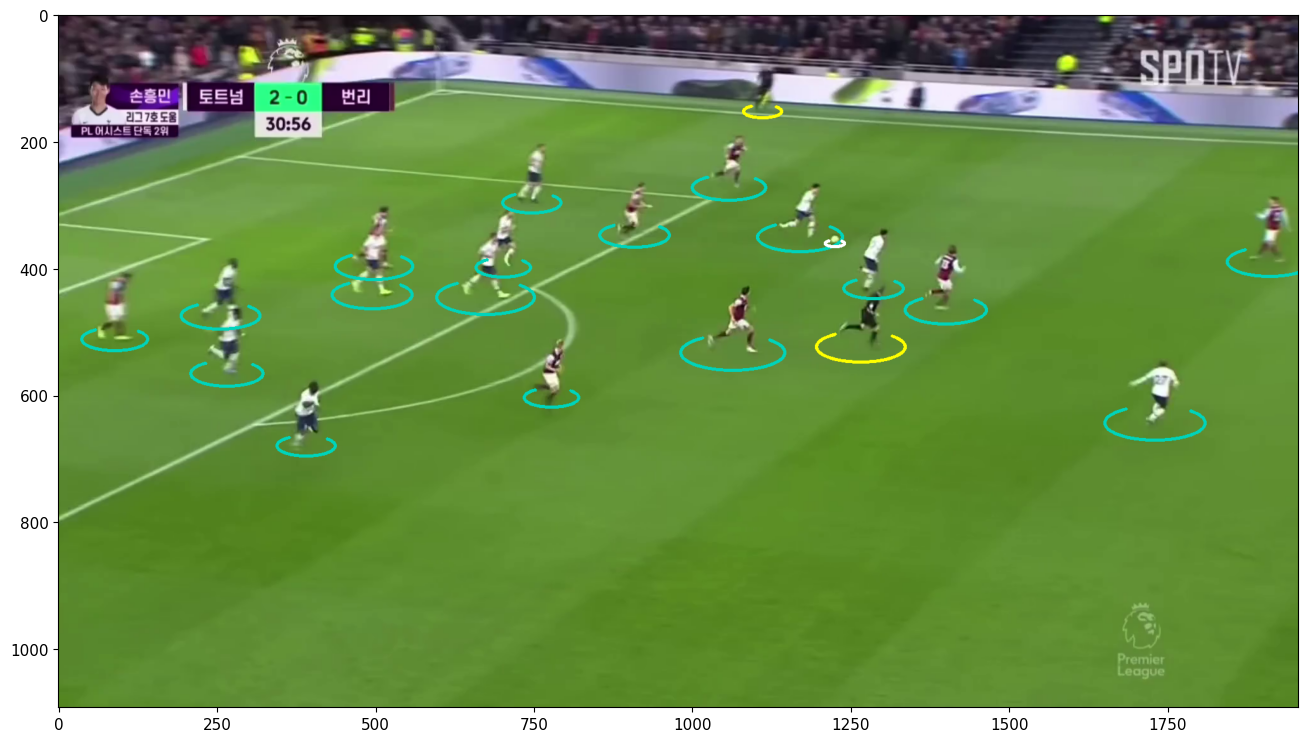

In [83]:
# initiate annotators
annotator = BaseAnnotator(
    colors=COLORS,
    thickness=THICKNESS)

# acquire video frame
frame = next(frame_iterator)

# run detector
results = model(frame, size=1280)
detections = Detection.from_results(
    pred=results.pred[0].cpu().numpy(),
    names=model.names)

# annotate video frame
annotated_image = annotator.annotate(
    image=frame,
    detections=detections)

# plot video frame
plot_image(annotated_image, 16)

# 3. Detect Ball possession

## 3-1. Color settings

In [18]:
# Maker contour : black
MARKER_CONTOUR_COLOR_HEX = "000000"
MARKER_CONTOUR_COLOR = Color.from_hex_string(MARKER_CONTOUR_COLOR_HEX)

# Player Maker : red
PLAYER_MARKER_FILL_COLOR_HEX = "FF0000"
PLAYER_MARKER_FILL_COLOR = Color.from_hex_string(PLAYER_MARKER_FILL_COLOR_HEX)

# Ball Maker : green
BALL_MARKER_FILL_COLOR_HEX = "00FF00"
BALL_MARKER_FILL_COLOR = Color.from_hex_string(BALL_MARKER_FILL_COLOR_HEX)

MARKER_CONTOUR_THICKNESS = 2
MARKER_WIDTH = 20
MARKER_HEIGHT = 20
MARKER_MARGIN = 10

# Distance in pixels from the player's bounding box where we consider the ball is in his possession
PLAYER_IN_POSSESSION_PROXIMITY = 30

## 3-2. Define Maker-related commentators

In [19]:
# calculates coordinates of possession marker
def calculate_marker(anchor: Point) -> np.ndarray:
    x, y = anchor.int_xy_tuple
    return(np.array([
        [x - MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN],
        [x, y - MARKER_MARGIN],
        [x + MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN]
    ]))


# draw single possession marker
def draw_marker(image: np.ndarray, anchor: Point, color: Color) -> np.ndarray:
    possession_marker_contour = calculate_marker(anchor=anchor)
    image = draw_filled_polygon(
        image=image,
        countour=possession_marker_contour,
        color=color)
    image = draw_polygon(
        image=image,
        countour=possession_marker_contour,
        color=MARKER_CONTOUR_COLOR,
        thickness=MARKER_CONTOUR_THICKNESS)
    return image


# dedicated annotator to draw possession markers on video frames
@dataclass
class MarkerAnnotator:

    color: Color

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            annotated_image = draw_marker(
                image=image,
                anchor=detection.rect.top_center,
                color=self.color)
        return annotated_image


## 3-3. Get ball possession player

In [20]:
from typing import List, Optional

# Resolves which player is currently in ball possession based on player-ball proximity
def get_player_in_possession(
    player_detections: List[Detection],
    ball_detections: List[Detection],
    proximity: int
) -> Optional[Detection]:
    if len(ball_detections) != 1:
        return None
    ball_detection = ball_detections[0]
    for player_detection in player_detections:
        if player_detection.rect.pad(proximity).contains_point(point=ball_detection.rect.center):
            return player_detection


# 4. Get Ball Detection in Single Frame

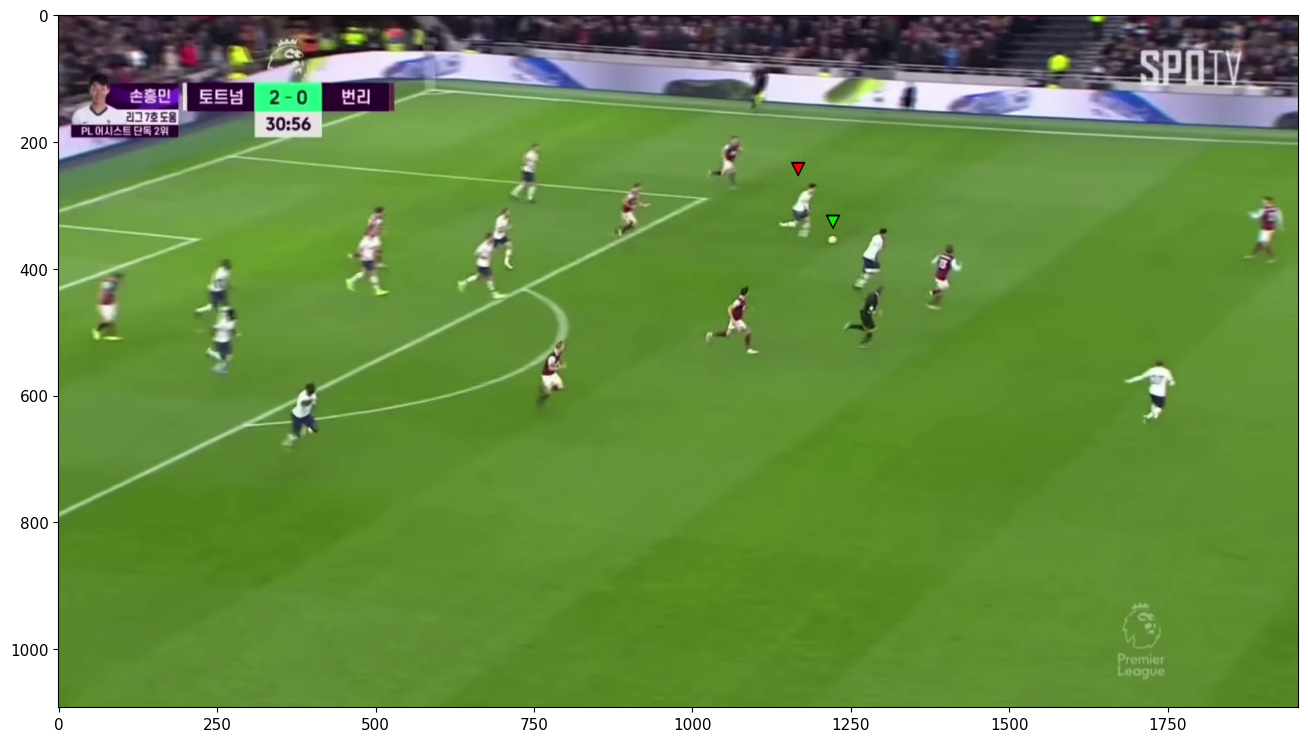

In [84]:
# initiate annotators
ball_marker_annotator = MarkerAnnotator(color=BALL_MARKER_FILL_COLOR)
player_marker_annotator = MarkerAnnotator(color=PLAYER_MARKER_FILL_COLOR)

# acquire video frame
frame = next(frame_iterator)

# run detector
results = model(frame, size=1280)
detections = Detection.from_results(
    pred=results.pred[0].cpu().numpy(),
    names=model.names)

# postprocess results
ball_detections = filter_detections_by_class(detections=detections, class_name="ball")
player_detections = filter_detections_by_class(detections=detections, class_name="player")
player_in_possession_detection = get_player_in_possession(
    player_detections=player_detections,
    ball_detections=ball_detections,
    proximity=PLAYER_IN_POSSESSION_PROXIMITY)

# annotate video frame
annotated_image = frame.copy()
annotated_image = ball_marker_annotator.annotate(
    image=annotated_image,
    detections=ball_detections)
annotated_image = player_marker_annotator.annotate(
    image=annotated_image,
    detections=[player_in_possession_detection] if player_in_possession_detection else [])

# plot video frame
plot_image(annotated_image, 16)

# 5. Get Full Video

## 5-1. Set Full Video path

In [41]:
SOURCE_VIDEO_PATH = f"{HOME}/clips/son_football.mp4"
TARGET_VIDEO_PATH = f"{HOME}/ball-possession/son_football.mp4"

## 5-2. Get Full Video

In [35]:
# Stores information about output video file, width and height of the frame must be equal to input video
@dataclass(frozen=True)
class VideoConfig:
    fps: float
    width: int
    height: int


# Create cv2.VideoWriter object that we can use to save output video
def get_video_writer(target_video_path: str, video_config: VideoConfig) -> cv2.VideoWriter:
    video_target_dir = os.path.dirname(os.path.abspath(target_video_path))
    os.makedirs(video_target_dir, exist_ok=True)
    return cv2.VideoWriter(
        target_video_path,
        fourcc=cv2.VideoWriter_fourcc(*"mp4v"),
        fps=video_config.fps,
        frameSize=(video_config.width, video_config.height),
        isColor=True
    )

# 6. Full Video Tracking

## 6-1. Set Full Video path

In [85]:
SOURCE_VIDEO_PATH = f"{HOME}/clips/son_football.mp4"
TARGET_VIDEO_PATH = f"{HOME}/tracking/son_football.mp4"

## 6-2. Format conversion

In [25]:
# converts List[Detection] into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: List[Detection], with_confidence: bool = True) -> np.ndarray:
    return np.array([
        [
            detection.rect.top_left.x,
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y,
            detection.confidence
        ] if with_confidence else [
            detection.rect.top_left.x,
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y
        ]
        for detection
        in detections
    ], dtype=float)


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: List[Detection],
    tracks: List[STrack]
) -> List[Detection]:
    detection_boxes = detections2boxes(detections=detections, with_confidence=False)
    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detection_boxes)
    track2detection = np.argmax(iou, axis=1)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            detections[detection_index].tracker_id = tracks[tracker_index].track_id
    return detections

# 6-3 text Annotator

In [26]:
# text annotator to display tracker_id
@dataclass
class TextAnnotator:
    background_color: Color
    text_color: Color
    text_thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            # if tracker_id is not assigned skip annotation
            if detection.tracker_id is None:
                continue

            # calculate text dimensions
            size, _ = cv2.getTextSize(
                str(detection.tracker_id),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                thickness=self.text_thickness)
            width, height = size

            # calculate text background position
            center_x, center_y = detection.rect.bottom_center.int_xy_tuple
            x = center_x - width // 2
            y = center_y - height // 2 + 10

            # draw background
            annotated_image = draw_filled_rect(
                image=annotated_image,
                rect=Rect(x=x, y=y, width=width, height=height).pad(padding=5),
                color=self.background_color)

            # draw text
            annotated_image = draw_text(
                image=annotated_image,
                anchor=Point(x=x, y=y + height),
                text=str(detection.tracker_id),
                color=self.text_color,
                thickness=self.text_thickness)
        return annotated_image

# 7. Final result

## 7-1. Set Full Video path

In [88]:
# settings
SOURCE_VIDEO_PATH = f"{HOME}/clips/son_football.mp4"
TARGET_VIDEO_PATH = f"{HOME}/final/football.mp4"

# SOURCE_VIDEO_PATH = f"{HOME}/clips/a9f16c_8.mp4"
# TARGET_VIDEO_PATH = f"{HOME}/final/a9f16c_8.mp4"

## 7-2. Set Video Width, Height and Fps

In [89]:
cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

print('width : ', width)
print('height : ', height)
print('fps : ', fps)

width :  1956
height :  1092
fps :  60.0


## 7-3. Get Video detection

In [90]:
from tqdm.notebook import tqdm

# initiate video writer
video_config = VideoConfig(
    fps=fps,
    width=width,
    height=height)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH,
    video_config=video_config)

# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

# initiate annotators
base_annotator = BaseAnnotator(
    colors=[
        BALL_COLOR,
        PLAYER_COLOR,
        PLAYER_COLOR,
        REFEREE_COLOR
    ],
    thickness=THICKNESS)

player_goalkeeper_text_annotator = TextAnnotator(
    PLAYER_COLOR, text_color=Color(255, 255, 255), text_thickness=2)
referee_text_annotator = TextAnnotator(
    REFEREE_COLOR, text_color=Color(0, 0, 0), text_thickness=2)

ball_marker_annotator = MarkerAnnotator(
    color=BALL_MARKER_FILL_COLOR)
player_in_possession_marker_annotator = MarkerAnnotator(
    color=PLAYER_MARKER_FILL_COLOR)


# initiate tracker
byte_tracker = BYTETracker(BYTETrackerArgs())

# loop over frames
for frame in tqdm(frame_iterator, total=750):
# for frame in tqdm(frame_iterator, total=100):
    # run detector
    results = model(frame, size=1280)
    detections = Detection.from_results(
        pred=results.pred[0].cpu().numpy(),
        names=model.names)

    # filter detections by class
    ball_detections = filter_detections_by_class(detections=detections, class_name="ball")
    referee_detections = filter_detections_by_class(detections=detections, class_name="referee")
    goalkeeper_detections = filter_detections_by_class(detections=detections, class_name="goalkeeper")
    player_detections = filter_detections_by_class(detections=detections, class_name="player")

    player_goalkeeper_detections = player_detections + goalkeeper_detections
    tracked_detections = player_detections + goalkeeper_detections + referee_detections

    # calculate player in possession
    player_in_possession_detection = get_player_in_possession(
        player_detections=player_goalkeeper_detections,
        ball_detections=ball_detections,
        proximity=PLAYER_IN_POSSESSION_PROXIMITY)

    # track
    tracks = byte_tracker.update(
        output_results=detections2boxes(detections=tracked_detections),
        img_info=frame.shape,
        img_size=frame.shape
    )
    tracked_detections = match_detections_with_tracks(detections=tracked_detections, tracks=tracks)

    tracked_referee_detections = filter_detections_by_class(detections=tracked_detections, class_name="referee")
    tracked_goalkeeper_detections = filter_detections_by_class(detections=tracked_detections, class_name="goalkeeper")
    tracked_player_detections = filter_detections_by_class(detections=tracked_detections, class_name="player")

    # annotate video frame
    annotated_image = frame.copy()
    annotated_image = base_annotator.annotate(
        image=annotated_image,
        detections=tracked_detections)

    annotated_image = player_goalkeeper_text_annotator.annotate(
        image=annotated_image,
        detections=tracked_goalkeeper_detections + tracked_player_detections)
    annotated_image = referee_text_annotator.annotate(
        image=annotated_image,
        detections=tracked_referee_detections)

    annotated_image = ball_marker_annotator.annotate(
        image=annotated_image,
        detections=ball_detections)
    annotated_image = player_marker_annotator.annotate(
        image=annotated_image,
        detections=[player_in_possession_detection] if player_in_possession_detection else [])

    # save video frame
    video_writer.write(annotated_image)

# close output video
video_writer.release()

  0%|          | 0/750 [00:00<?, ?it/s]